# Blood Smears Classification

We'll compare the performance of a dense neural network and of a convolutional neural network with a dense top for the classification of blood smears in a dataser of blood smears containing blood cells with and without malaria. 

## Load Malaria Dataset

We'll load and uncompress the single cell dataset from 
https://lhncbc.nlm.nih.gov/LHC-research/LHC-projects/image-processing/malaria-datasheet.html

The Malaria dataset was published in S. Rajaraman, S. K. Antani, M. Poost- chi, K. Silamut, Md A. Hossain, R. J. Maude, S. Jaeger, and G. R. Thoma. Pre-trained convolutional neural net- works as feature extractors toward improved malaria parasite detection in thin blood smear images. PeerJ, 6:e4568, 2018.
It is available at https://data.lhncbc.nlm.nih.gov/public/Malaria/cell_images.zip

In [1]:
import os
from torchvision.datasets.utils import download_url, _extract_zip

dataset_path = os.path.join(".", "blood_smears_dataset")
if not os.path.exists(dataset_path):
    url = "https://data.lhncbc.nlm.nih.gov/public/Malaria/cell_images.zip"
    download_url(url, ".")
    _extract_zip("cell_images.zip", dataset_path, None)
    os.remove("cell_images.zip")

We'll define the path to the directories containing the `Infected` and `Parasitized` images.

In [2]:
import glob

base_dir = os.path.join(dataset_path, "cell_images")
uninfected_files = glob.glob(os.path.join(base_dir, "Uninfected", "*.png"))
parasitized_files = glob.glob(os.path.join(base_dir, "Parasitized", "*.png"))


## Visualize Data

We'll then visualize some of the data.

In [3]:
def plot_blood_smears(title, files):
    import matplotlib.pyplot as plt

    fig, axs = plt.subplots(3, 3, figsize=(8, 8))
    for i, ax in enumerate(axs.ravel()):
        image = plt.imread(files[i])
        ax.imshow(image)
        
    fig.suptitle(title, fontsize=16)
    plt.show()

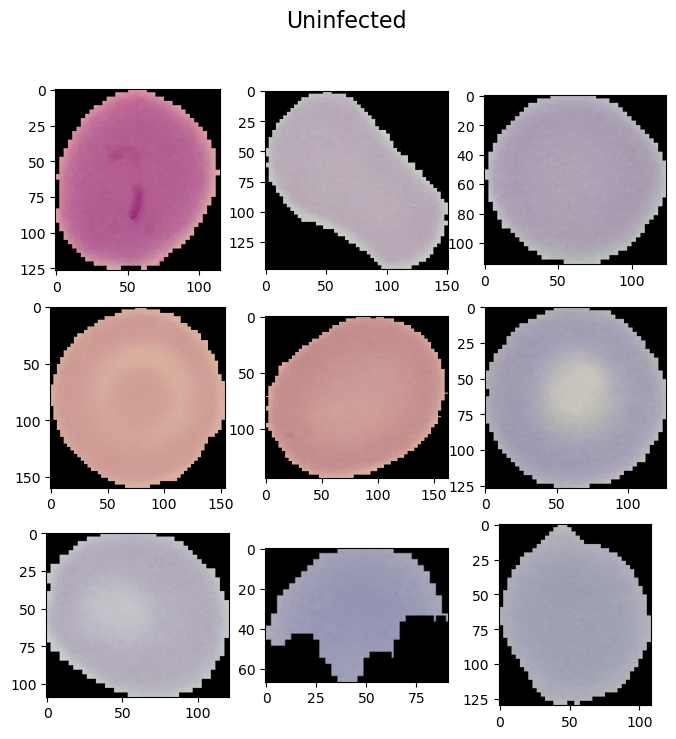

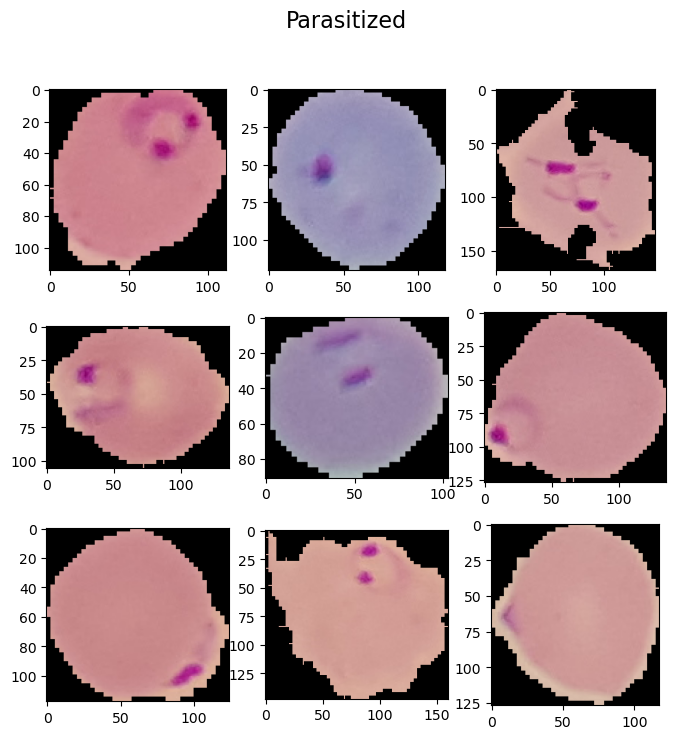

In [4]:
#from fnc_blood_smears import plot_blood_smears

plot_blood_smears("Uninfected", uninfected_files)
plot_blood_smears("Parasitized", parasitized_files)

## Data Preprocessing

We'll define a pipeline to resize the images to 28 by 28 pixels and convert them to PyTorch tensors (note that `ToTensor()` also normalizes their values between 0 and 1) ...

In [5]:
from torchvision.transforms import Compose, Resize, ToTensor

input_transform = Compose([Resize((28, 28)), ToTensor()])

... we set up a dataset where images are loaded from a structured directory (`base_dir`) ...

In [6]:
from torch import tensor

def target_transform(target):
    return tensor(abs(1 - target)).float().unsqueeze(-1)

In [7]:
from torchvision.datasets import ImageFolder

dataset = ImageFolder(base_dir, 
                      transform=input_transform, 
                      target_transform=target_transform)

... creates a subset the full dataset and split it into `train` and `test` sets ...

In [8]:
from torch import randperm
from torch.utils.data import random_split, Subset

images_num = 5000
images_idx = randperm(len(dataset))[:images_num]
subset = Subset(dataset, images_idx)

train_size = int(0.8 * len(subset))
test_size = len(subset) - train_size
train, test = random_split(subset, [train_size, test_size])

... and define the dataloaders for both sets. For the training, we'll set `batch_size = 32`.

In [9]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train, batch_size=32, shuffle=True)
test_loader = DataLoader(test, batch_size=124, shuffle=False)

## Dense Neural Network

We'll define a dense neural network using `deeplay`. The FCNN has 2 layers with 128 features.

In [10]:
import deeplay as dl
from torch.nn import Sigmoid

dnn = dl.MultiLayerPerceptron(in_features=28 * 28 * 3,
                               hidden_features=[128, 128],
                               out_features=1,
                               out_activation=Sigmoid)

We'll define a classifier based on the FCNN architecture, including loss function, evaluation metrics and othe hyperparameters ...

In [11]:
import torchmetrics as tm

dnn_classifier_template = dl.BinaryClassifier(model=dnn,
                                              optimizer=dl.RMSprop(lr=.001))

dnn_classifier = dnn_classifier_template.create()

print(dnn_classifier)

BinaryClassifier(
  (loss): BCELoss()
  (train_metrics): MetricCollection(
    (BinaryAccuracy): BinaryAccuracy(),
    prefix=train
  )
  (val_metrics): MetricCollection(
    (BinaryAccuracy): BinaryAccuracy(),
    prefix=val
  )
  (test_metrics): MetricCollection(
    (BinaryAccuracy): BinaryAccuracy(),
    prefix=test
  )
  (model): MultiLayerPerceptron(
    (blocks): LayerList(
      (0): LayerActivationNormalization(
        (layer): Linear(in_features=2352, out_features=128, bias=True)
        (activation): ReLU()
        (normalization): Identity()
      )
      (1): LayerActivationNormalization(
        (layer): Linear(in_features=128, out_features=128, bias=True)
        (activation): ReLU()
        (normalization): Identity()
      )
      (2): LayerActivationNormalization(
        (layer): Linear(in_features=128, out_features=1, bias=True)
        (activation): Sigmoid()
        (normalization): Identity()
      )
    )
  )
  (optimizer): RMSprop[RMSprop](lr=0.001, params=<ge

... and a trainer including other hyperparameters ...

In [12]:
dnn_trainer = dl.Trainer(max_epochs=20, accelerator="auto")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


We'll start the training and visualize the evaluation metrics.

In [13]:
dnn_trainer.fit(dnn_classifier, train_loader)

/Users/giovannivolpe/miniconda3/envs/py310/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name          | Type                 | Params
-------------------------------------------------------
0 | loss          | BCELoss              | 0     
1 | train_metrics | MetricCollection     | 0     
2 | val_metrics   | MetricCollection     | 0     
3 | test_metrics  | MetricCollection     | 0     
4 | model         | MultiLayerPerceptron | 317 K 
5 | optimizer     | RMSprop              | 0     
-------------------------------------------------------
317 K     Trainable params
0         Non-trainable params
317 K     Total params
1.271     Total estimated model params size (MB)
/Users/giovannivolpe/miniconda3/envs/py310/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a 

Epoch 19: 100%|██████████| 125/125 [00:04<00:00, 27.88it/s, v_num=13, train_loss_step=0.612, trainBinaryAccuracy_step=0.656, train_loss_epoch=0.568, trainBinaryAccuracy_epoch=0.704]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 125/125 [00:04<00:00, 27.82it/s, v_num=13, train_loss_step=0.612, trainBinaryAccuracy_step=0.656, train_loss_epoch=0.568, trainBinaryAccuracy_epoch=0.704]


We'll calculate the performance over the test set.

In [14]:
_ = dnn_trainer.test(dnn_classifier, test_loader)

/Users/giovannivolpe/miniconda3/envs/py310/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 9/9 [00:01<00:00,  5.21it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
testBinaryAccuracy_epoch    0.6800000071525574
     test_loss_epoch        0.5998501777648926
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


## ROC curve and AUC

We'll use the function `plot_ROC_AUC` to get the ground truth and predictions for all the images in the test set, calculate the ROC and AUC, and visualize the results.

```python

```

In [15]:
def plot_AUROC(classifier, dataset):
    from torch import tensor, stack
    from sklearn.metrics import roc_curve, auc
    from matplotlib import pyplot as plt

    # calculate predictions
    images, gt = zip(*dataset)
    pred = classifier(tensor(stack(images))).tolist()
    
    # calculate the ROC curve
    fpr, tpr, thresholds = roc_curve(gt, pred, pos_label=1) 
    auroc = auc(fpr, tpr) 

    # plot the ROC curve
    plt.figure(figsize=(5, 5))
    plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auroc:.3f})", linewidth=2)
    plt.title("ROC curve")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.axis("square")
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.legend(loc = 'center right')
    plt.show()

    return images, gt, pred, auroc

/var/folders/hq/wmcbgp7s56b98c9mjf167rz40000gn/T/ipykernel_95458/257835295.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred = classifier(tensor(stack(images))).tolist()


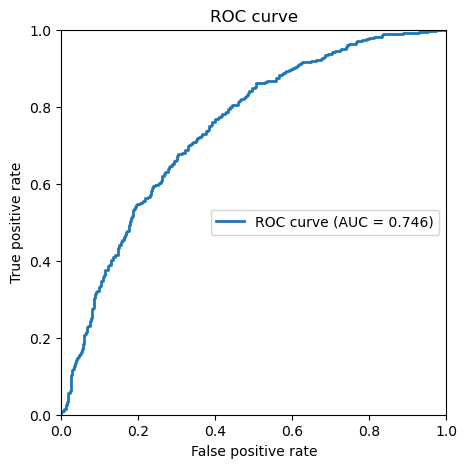

In [16]:
#from fnc_blood_smears import plot_ROC_AUC

_ = plot_AUROC(classifier=dnn_classifier, dataset=test)

## Convolutional Neural Network with a Dense Top

We'll now build a convolutional neural network a dense top using `deeplay` ...


In [17]:
from torch.nn import AdaptiveAvgPool2d, MaxPool2d

cnn = dl.Sequential(
    dl.ConvolutionalNeuralNetwork(
        in_channels=3, 
        hidden_channels=[32, 32, 64], 
        out_channels=64,
    ),
    dl.Layer(AdaptiveAvgPool2d, output_size=1),
    dl.MultiLayerPerceptron(
        in_features=64, 
        hidden_features=[], 
        out_features=1,
        out_activation=Sigmoid,
    )
)
cnn[0].blocks[2].pool.configure(MaxPool2d, kernel_size=2)

... define a classifier using the CNN ...

In [18]:
cnn_classifier_template = dl.BinaryClassifier(
    model=cnn, 
    optimizer=dl.RMSprop(lr=.001),
)

cnn_classifier = cnn_classifier_template.create()

print(cnn_classifier)

BinaryClassifier(
  (loss): BCELoss()
  (train_metrics): MetricCollection(
    (BinaryAccuracy): BinaryAccuracy(),
    prefix=train
  )
  (val_metrics): MetricCollection(
    (BinaryAccuracy): BinaryAccuracy(),
    prefix=val
  )
  (test_metrics): MetricCollection(
    (BinaryAccuracy): BinaryAccuracy(),
    prefix=test
  )
  (model): Sequential(
    (0): ConvolutionalNeuralNetwork(
      (blocks): LayerList(
        (0): PoolLayerActivationNormalization(
          (pool): Identity()
          (layer): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): ReLU()
          (normalization): Identity()
        )
        (1): PoolLayerActivationNormalization(
          (pool): Identity()
          (layer): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): ReLU()
          (normalization): Identity()
        )
        (2): PoolLayerActivationNormalization(
          (pool): MaxPool2d(kernel_size=2, stride=2, padding=

... train it ...

In [19]:
cnn_trainer = dl.Trainer(max_epochs=20, accelerator="auto")

cnn_trainer.fit(cnn_classifier, train_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/giovannivolpe/miniconda3/envs/py310/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name          | Type             | Params
---------------------------------------------------
0 | loss          | BCELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | test_metrics  | MetricCollection | 0     
4 | model         | Sequential       | 65.6 K
5 | optimizer     | RMSprop          | 0     
---------------------------------------------------
65.6 K    Trainable params
0         Non-trainable params
65.6 K    Total params
0.263     Total estimated model params size (MB)
/Users/giovannivolpe/miniconda3/envs/py310/lib/python3.10/site-packages/lightning/pyto

Epoch 19: 100%|██████████| 125/125 [00:08<00:00, 15.39it/s, v_num=14, train_loss_step=0.233, trainBinaryAccuracy_step=0.906, train_loss_epoch=0.192, trainBinaryAccuracy_epoch=0.937] 

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 125/125 [00:08<00:00, 15.37it/s, v_num=14, train_loss_step=0.233, trainBinaryAccuracy_step=0.906, train_loss_epoch=0.192, trainBinaryAccuracy_epoch=0.937]


... evaluate the performance over the test set ...

In [20]:
_ = cnn_trainer.test(cnn_classifier, test_loader)

/Users/giovannivolpe/miniconda3/envs/py310/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 9/9 [00:01<00:00,  7.57it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
testBinaryAccuracy_epoch    0.9399999976158142
     test_loss_epoch        0.19908171892166138
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


... and display the ROC curve with the AUC value.

/var/folders/hq/wmcbgp7s56b98c9mjf167rz40000gn/T/ipykernel_95458/257835295.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred = classifier(tensor(stack(images))).tolist()


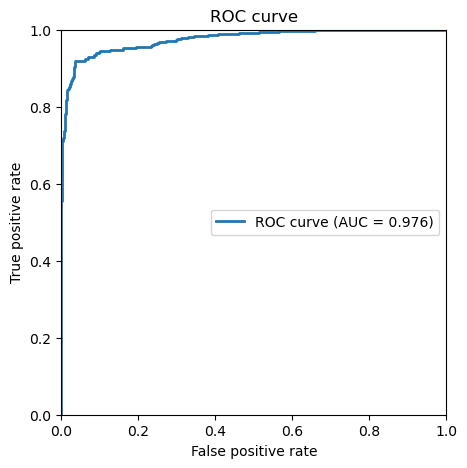

In [21]:
images, gt, pred, _ = plot_AUROC(classifier=cnn_classifier, dataset=test)

## Failure analysis

We'll use a function to visualize some of the wrongly classified cells, looking for common patterns.

```python

```

In [22]:
def plot_failures(images, gt, pred, threshold=.5, plot_num=5):
    from matplotlib import pyplot as plt 
    from numpy import array, squeeze
    
    pred = array(pred).squeeze()
    gt = array(gt).squeeze()
    images = array(images)

    false_positives = (pred > threshold) & (gt == 0)
    false_positives_images = images[false_positives]

    false_negatives = (pred < threshold) & (gt == 1)
    false_negatives_images = images[false_negatives]

    plt.figure(figsize=(plot_num * 2, 5))
    for i in range(plot_num):
        # false positives
        plt.subplot(2, plot_num, i + 1)
        plt.imshow(false_positives_images[i].transpose(1, 2, 0))
        if i == 0:
            plt.title("False positives", fontsize=16, y=1.1)

        # false negatives
        plt.subplot(2, plot_num, plot_num + i + 1)
        plt.imshow(false_negatives_images[i].transpose(1, 2, 0))
        if i == 0:
            plt.title("False negatives", fontsize=16, y=1.1)

    plt.tight_layout()
    plt.show()

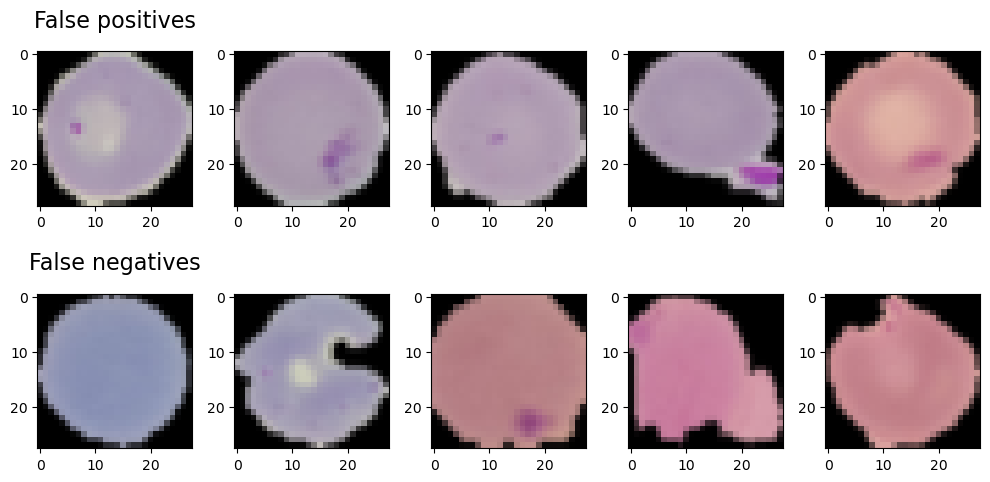

In [23]:
#from fnc_blood_smears import plot_failure

plot_failures(images, gt, pred)

## Access Filters

We can access the filters used by the neural network. The follwoing code accesses the 32nd filter's weights in the first convolutional layer of the CNN. It navigates through the model's first module (`model[0]`), selects the initial block (`blocks[0]`), and then targets the layer's weights (`layer.weight[31]`). 

In [35]:
filter = cnn_classifier.model[0].blocks[0].layer.weight[31]

print(filter)

tensor([[[-0.1473,  0.1200, -0.1294],
         [-0.1625,  0.1281,  0.0636],
         [ 0.1405,  0.1217, -0.0676]],

        [[-0.0389, -0.1891,  0.0767],
         [-0.0669, -0.1158, -0.0231],
         [ 0.1550, -0.0405, -0.2821]],

        [[-0.2096,  0.1170,  0.0083],
         [-0.0091, -0.0033,  0.1636],
         [-0.0647,  0.0404,  0.0090]]], grad_fn=<SelectBackward0>)


## Activations and Grad-CAM

To visualize the network features, we'll use `hooks`, functions that allows us to access the information that the model sees during forward and backward passes, such as activations and gradients, respectively. We'll define them as context manager classes, so that we can use them with the `with` statement:

```python

```

```python

```

The use of context managers (`with` statements) for hooks is a good practice. It ensures that the hooks are properly set up and removed when they are no longer needed, preventing potential side effects or memory leaks. This is particularly important in complex neural network models where maintaining computational efficiency and correctness is crucial.

We'll randomly pick the image of an infected smear.

In [102]:
import numpy as np
from torch import cat

# Convert the ground truth labels (gt) to a categorical format and then to a list.
gt_as_list = (cat(gt) == 1).tolist()

# Find the indices where the ground truth labels are equal to 1.
indices = np.where(gt_as_list)[0]

# Randomly select one index from those indices.
index = np.random.choice(indices, 1)[0]

# Retrieve the image corresponding to the selected index.
image = images[index]

Activations and gradients at a specific layer can be obtained from the forward and backward pass, respectively ...

In [103]:
class fwd_hook():
    # Initializer method for the fwd_hook class.
    def __init__(self, model):
        # Register a forward hook to the provided model. The hook is set to the hook_func method.
        # This hook will be called every time the forward method of the model is executed.
        self.hook = model.register_forward_hook(self.hook_func)

    # The forward hook function.
    def hook_func(self, model, i, o):
        # This function is called during the forward pass of the model.
        # 'model' is the model to which the hook is attached.
        # 'i' is the input to the model's layer.
        # 'o' is the output from the model's layer.

        # Print a message indicating the forward hook is running.
        print("Forward hook running ...") 

        # Detach the output 'o' from the current computation graph and clone it.
        # This prevents any modifications to 'o' from affecting the original tensor,
        # and avoids potential issues with backpropagation.
        self.stored = o.detach().clone()

        # Print the size of the activations (the output tensor).
        print(f"Activations size: {self.stored.size()}")

    # Enter method for the context manager.
    def __enter__(self, *args): 
        # When entering the context (using the 'with' statement), return this object.
        return self
    
    # Exit method for the context manager.
    def __exit__(self, *args): 
        # When exiting the context, remove the forward hook from the model.
        # This is important for resource management and to ensure that the hook
        # does not remain active beyond its intended scope.
        self.hook.remove()

In [104]:
class bwd_hook():
    # Initializer method for the bwd_hook class.
    def __init__(self, model):
        # Register a full backward hook to the provided model. The hook is set to the hook_func method.
        # This hook will be called every time the backward pass of the model is executed.
        self.hook = model.register_full_backward_hook(self.hook_func)

    # The backward hook function.
    def hook_func(self, model, gi, go):
        # This function is called during the backward pass of the model.
        # 'model' is the model to which the hook is attached.
        # 'gi' represents the gradients with respect to the input.
        # 'go' represents the gradients with respect to the output.

        # Print a message indicating the backward hook is running.
        print("Backward hook running ...")

        # Detach the first output gradient 'go[0]' from the current computation graph and clone it.
        # This prevents any modifications to 'go[0]' from affecting the original tensor,
        # and avoids potential issues with backpropagation.
        # Note: go[0] is used because go is a tuple of gradients, one for each output.
        self.stored = go[0].detach().clone()

        # Print the size of the stored gradients.
        print(f"Gradients size: {self.stored.size()}")

    # Enter method for the context manager.
    def __enter__(self, *args): 
        # When entering the context (using the 'with' statement), return this object.
        # This enables the use of the 'with' statement with instances of this class.
        return self
    
    # Exit method for the context manager.
    def __exit__(self, *args): 
        # When exiting the context, remove the backward hook from the model.
        # This is important to ensure that the hook is only active during the intended scope
        # and to release any resources associated with the hook.
        self.hook.remove()

In [105]:
#from fnc_blood_smears import fwd_hook, bwd_hook

layer = cnn_classifier.model[0].blocks[3].layer

# Using backward and forward hooks on the specified layer
with bwd_hook(layer) as bh, fwd_hook(layer) as fh:
    # Forward pass through the model with the given image
    pred = cnn_classifier.model(image.unsqueeze(0))
    # Executing the backward pass for backpropagation
    pred.backward()

activations = fh.stored
gradients = bh.stored

Forward hook running ...
Activations size: torch.Size([1, 64, 14, 14])
Backward hook running ...
Gradients size: torch.Size([1, 64, 14, 14])


... we can plot the activations ...

In [106]:
def plot_activations(activations, cols=8):
    from matplotlib import pyplot as plt

    rows = -(activations.shape[0] // -cols)

    fig, axs = plt.subplots(rows, cols, figsize=(2 * cols, 2 * rows))
    for i, ax in enumerate(axs.ravel()):
        ax.axis('off')
        if i < activations.shape[0]:
            ax.imshow(activations[i].numpy())
            ax.set_title(i)

    fig.tight_layout()
    plt.show()

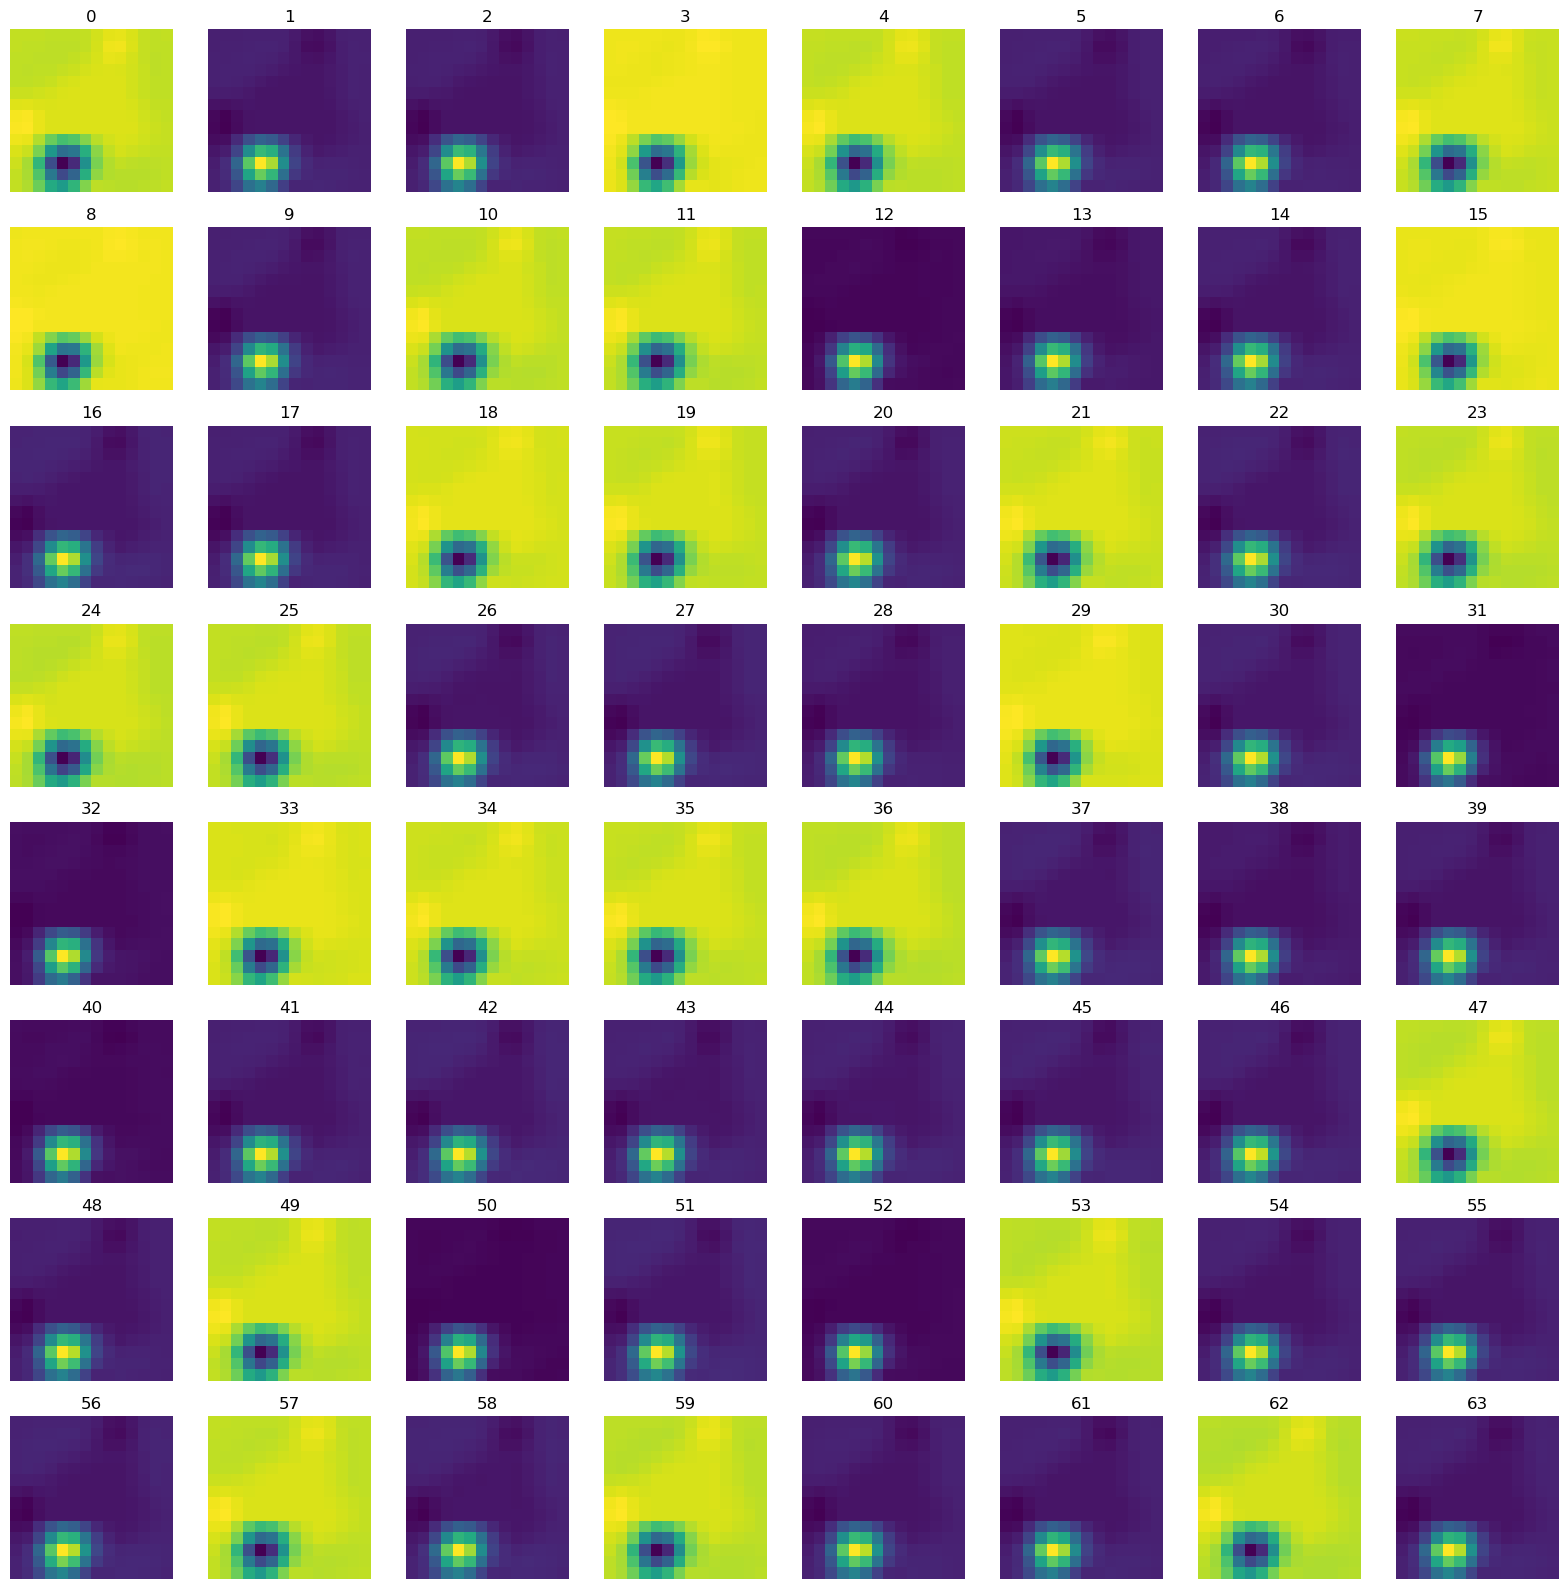

In [107]:
#from fnc_blood_smears import plot_activations

plot_activations(activations[0])

... or combine gradients and activations to calculate Grad-CAM and inspect on which part of an image the CNN focuses on to predict its outputs. 

In [108]:
import matplotlib.image as mpimg

image_hr = mpimg.imread(dataset.imgs[subset.indices[test.indices[index]]][0])

In [109]:
def plot_gradcam(image, grad_cam):
    from matplotlib import pyplot as plt
    import skimage

    grad_cam = skimage.transform.resize(grad_cam, image.shape, order=2)
    grad_cam = skimage.exposure.rescale_intensity(grad_cam, out_range=(0.25, 1))

    plt.figure(figsize=(12, 5)) 

    plt.subplot(1, 3, 1)
    plt.imshow(image, interpolation="bilinear")
    plt.title("Original image")
    plt.axis("off")
    
    plt.subplot(1, 3, 2)
    plt.imshow(grad_cam.mean(axis=-1), interpolation="bilinear")
    plt.title("Grad-CAM")
    plt.axis("off")
    
    plt.subplot(1, 3, 3)
    plt.imshow(image * grad_cam)
    plt.title("Overlay")
    plt.axis("off")
    
    plt.tight_layout()
    plt.show()

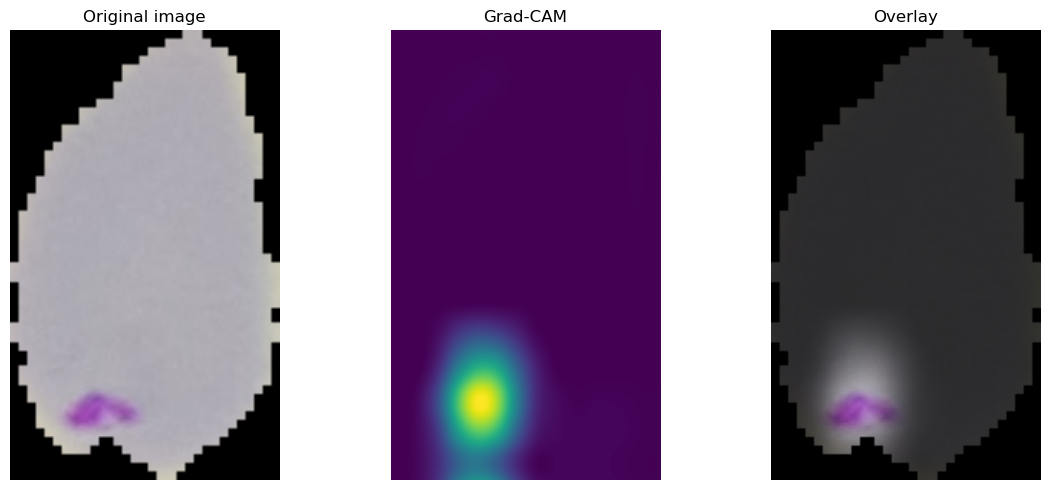

In [110]:
from torch.nn.functional import relu

pooled_gradients = gradients[0].mean(dim=[1,2], keepdim=True)
grad_cam = relu((pooled_gradients * activations[0]).sum(0)).detach().numpy()

#from fnc_blood_smears import plot_gradcam

plot_gradcam(image_hr, grad_cam)